In [1]:
import warnings; warnings.simplefilter('ignore')

import hotspot
import scanpy as sc
import muon as mu
import anndata
#import scvelo as scv

import numpy as np
import mplscience

In [2]:
adata = anndata.read_h5ad("/home/lab401_B/scRNA_downstream/cellrank/scRNA_pig_oogenesis/Pig_ovary_germ.h5ad")
#scv.pl.proportions(adata)
adata

AnnData object with n_obs × n_vars = 579 × 27339
    obs: 'Clusters', '_X', '_Y', 'seurat_cluster'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'mycolor', 'seurat_cluster_colors'
    obsm: 'X_umap'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [3]:
adata.layers["counts"] = adata.X.copy()
adata

AnnData object with n_obs × n_vars = 579 × 27339
    obs: 'Clusters', '_X', '_Y', 'seurat_cluster'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'mycolor', 'seurat_cluster_colors'
    obsm: 'X_umap'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced', 'counts'

In [4]:
adata.var['MT'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['MT'], percent_top=None, log1p=False, inplace=True)

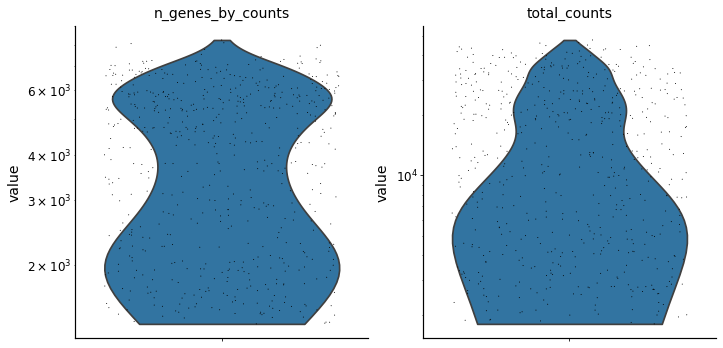

In [5]:
with mplscience.style_context():
    sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],
                jitter=0.4, multi_panel=True, log=True)

In [6]:
sc.pp.filter_cells(adata, min_genes=1000)
sc.pp.filter_genes(adata, min_cells=10)

In [7]:

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.scale(adata)
sc.tl.pca(adata)

In [8]:
adata.layers["log_normalized"] = adata.X.copy()
adata

AnnData object with n_obs × n_vars = 579 × 15574
    obs: 'Clusters', '_X', '_Y', 'seurat_cluster', 'n_genes_by_counts', 'total_counts', 'total_counts_MT', 'pct_counts_MT', 'n_genes'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MT', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std'
    uns: 'mycolor', 'seurat_cluster_colors', 'log1p', 'pca'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced', 'counts', 'log_normalized'

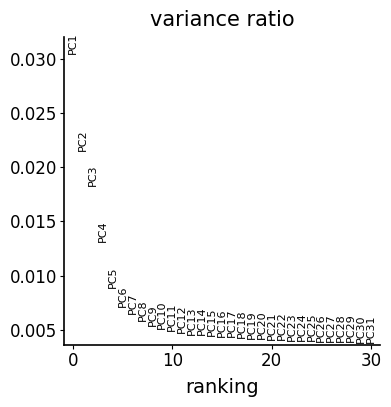

In [9]:
with mplscience.style_context():
    sc.pl.pca_variance_ratio(adata)

In [10]:
# rerun with fewer components
sc.tl.pca(adata, n_comps=10)

In [11]:
adata

AnnData object with n_obs × n_vars = 579 × 15574
    obs: 'Clusters', '_X', '_Y', 'seurat_cluster', 'n_genes_by_counts', 'total_counts', 'total_counts_MT', 'pct_counts_MT', 'n_genes'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MT', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std'
    uns: 'mycolor', 'seurat_cluster_colors', 'log1p', 'pca'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced', 'counts', 'log_normalized'

In [12]:
adata.layers["counts"]

<579x15574 sparse matrix of type '<class 'numpy.float32'>'
	with 2405730 stored elements in Compressed Sparse Row format>

In [13]:
import scipy
adata.layers["counts"]=scipy.sparse.csc_matrix(adata.layers["counts"])
adata.layers["counts"]

<579x15574 sparse matrix of type '<class 'numpy.float32'>'
	with 2405730 stored elements in Compressed Sparse Column format>

In [14]:
# Create the Hotspot object and the neighborhood graph
# hotspot works a lot faster with a csc matrix!
adata.layers["counts_csc"] = adata.layers["counts"].tocsc()
hs = hotspot.Hotspot(
    adata,
    layer_key="counts_csc",
    model='danb',
    latent_obsm_key="X_pca",
    umi_counts_obs_key="total_counts"
)

hs.create_knn_graph(
    weighted_graph=False, n_neighbors=30,
)

In [15]:
hs_results = hs.compute_autocorrelations(jobs=4)

hs_results.head(15)

100%|█████████████████████████████████████████████████████████████| 15574/15574 [00:15<00:00, 1017.75it/s]


,C,Z,Pval,FDR
Gene,,,,
RN18S,0.323256,377.925826,0.0,0.0
SYCP3,0.714073,192.305178,0.0,0.0
TEX30,0.713053,168.662243,0.0,0.0
LOC110260131,0.541727,164.659452,0.0,0.0
SPDYA,0.572388,159.229057,0.0,0.0
SYCP1,0.572272,156.332008,0.0,0.0
IQCB1,0.567422,155.928782,0.0,0.0
LOC100157935,0.537172,155.639405,0.0,0.0
MOS,0.515059,151.200300,0.0,0.0


In [16]:
# Select the genes with significant lineage autocorrelation
hs_genes = hs_results.loc[hs_results.FDR < 0.05].sort_values('Z', ascending=False).head(500).index

# Compute pair-wise local correlations between these genes
lcz = hs.compute_local_correlations(hs_genes, jobs=10)

Computing pair-wise local correlation on 500 features...


100%|██████████████████████████████████████████████████████████| 124750/124750 [00:09<00:00, 13714.55it/s]


In [17]:
modules = hs.create_modules(
    min_gene_threshold=15, core_only=True, fdr_threshold=0.05
)

modules.value_counts()

 1     133
-1      68
 2      66
 3      62
 9      32
 10     28
 11     23
 8      21
 6      20
 7      17
 5      15
 4      15
Name: Module, dtype: int64

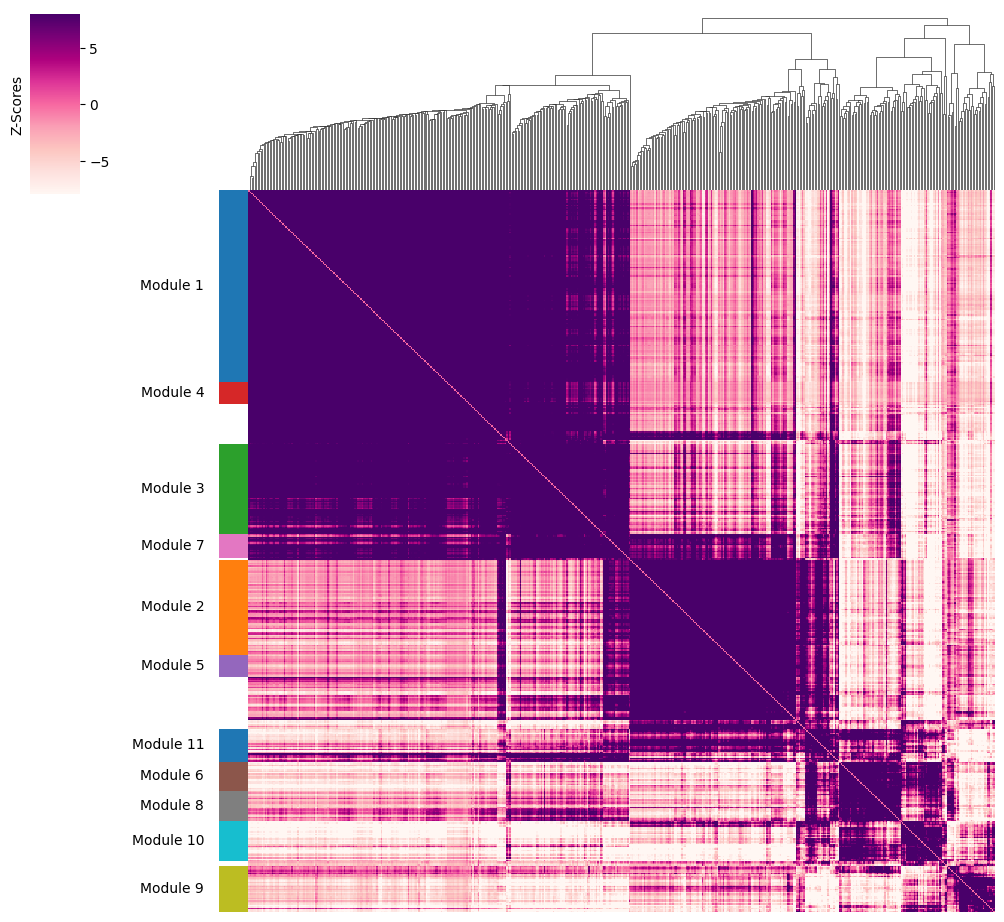

In [19]:
hs.plot_local_correlations(z_cmap='RdPu')

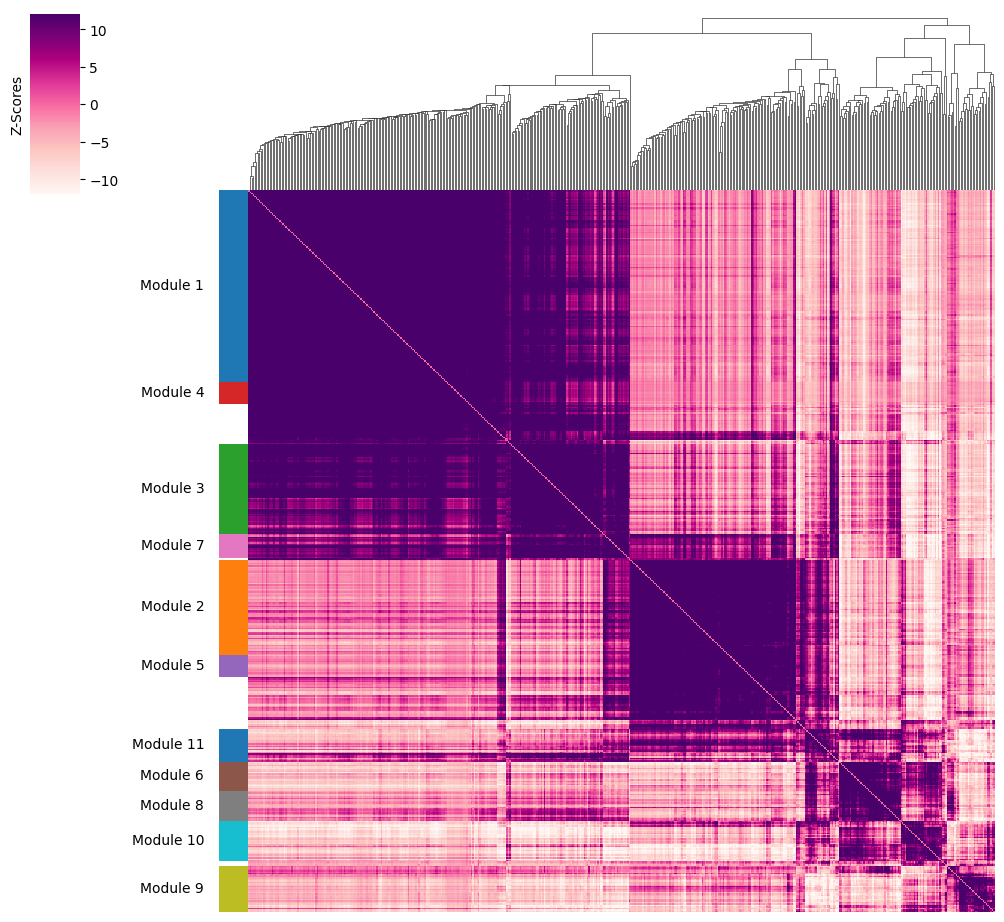

In [20]:
import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt

with mpl.rc_context({'figure.figsize': (5, 5)}):
   fig = hs.plot_local_correlations(vmin=-12, vmax=12,z_cmap='RdPu')

plt.savefig(fname="./figures/hotspot_dpi1200_final.pdf",dpi=1200, format="pdf")


In [114]:
import pandas as pd
# Show the top genes for a module

module = 11

results = hs.results.join(hs.modules)
results = results.loc[results.Module == module]

results.sort_values('Z', ascending=False).head(10)

results.to_csv("./figures/module11.csv",index=True,sep=',')

In [101]:
results

,C,Z,Pval,FDR,Module
Gene,,,,,
LOC110260131,0.541727,164.659452,0.0,0.0,1.0
MOS,0.515059,151.200300,0.0,0.0,1.0
LOC100621706,0.569818,143.835145,0.0,0.0,1.0
KHDC3L,0.102294,142.162302,0.0,0.0,1.0
ACCSL,0.601821,126.208246,0.0,0.0,1.0
...,...,...,...,...,...
TM2D3,0.358740,45.895564,0.0,0.0,1.0
RRAGA,0.365284,45.598575,0.0,0.0,1.0
LOC110260852,0.294506,45.485645,0.0,0.0,1.0


In [21]:
module_scores = hs.calculate_module_scores()

module_scores.head()

Computing scores for 11 modules...


100%|█████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  8.08it/s]


,1,2,3,4,5,6,7,8,9,10,11
E45:AAAGAACAGATTGAGTx,-3.459996,-3.441171,-2.594331,-0.805552,-1.130163,2.059863,-1.992477,0.806006,-1.446986,3.494590,1.347505
E45:AACTTCTAGTCATTGCx,-3.211987,-3.449824,-3.171064,-0.709821,-0.850822,-3.501112,-2.251108,-4.631593,2.882549,0.925182,-3.891678
E45:AAGCGAGTCAGGACGAx,-3.194106,-2.334566,-2.762765,-0.762683,-0.551594,-0.175439,-1.365799,-1.488119,-0.149059,2.121560,0.463264
E45:AAGGTAAGTACGTGAGx,-3.194930,0.196964,-2.153921,-0.747144,0.168642,1.005429,-0.328998,-0.651010,-2.785305,2.967612,3.507570
E45:AATGGAACAATTTCCTx,-3.002698,-2.625121,-2.945726,-0.693512,-0.537966,-2.287384,-1.569144,-3.236262,2.941656,0.406098,-2.045725


In [22]:
module_cols = []
for c in module_scores.columns:
    key = f"Module {c}"
    adata.obs[key] = module_scores[c]
    module_cols.append(key)

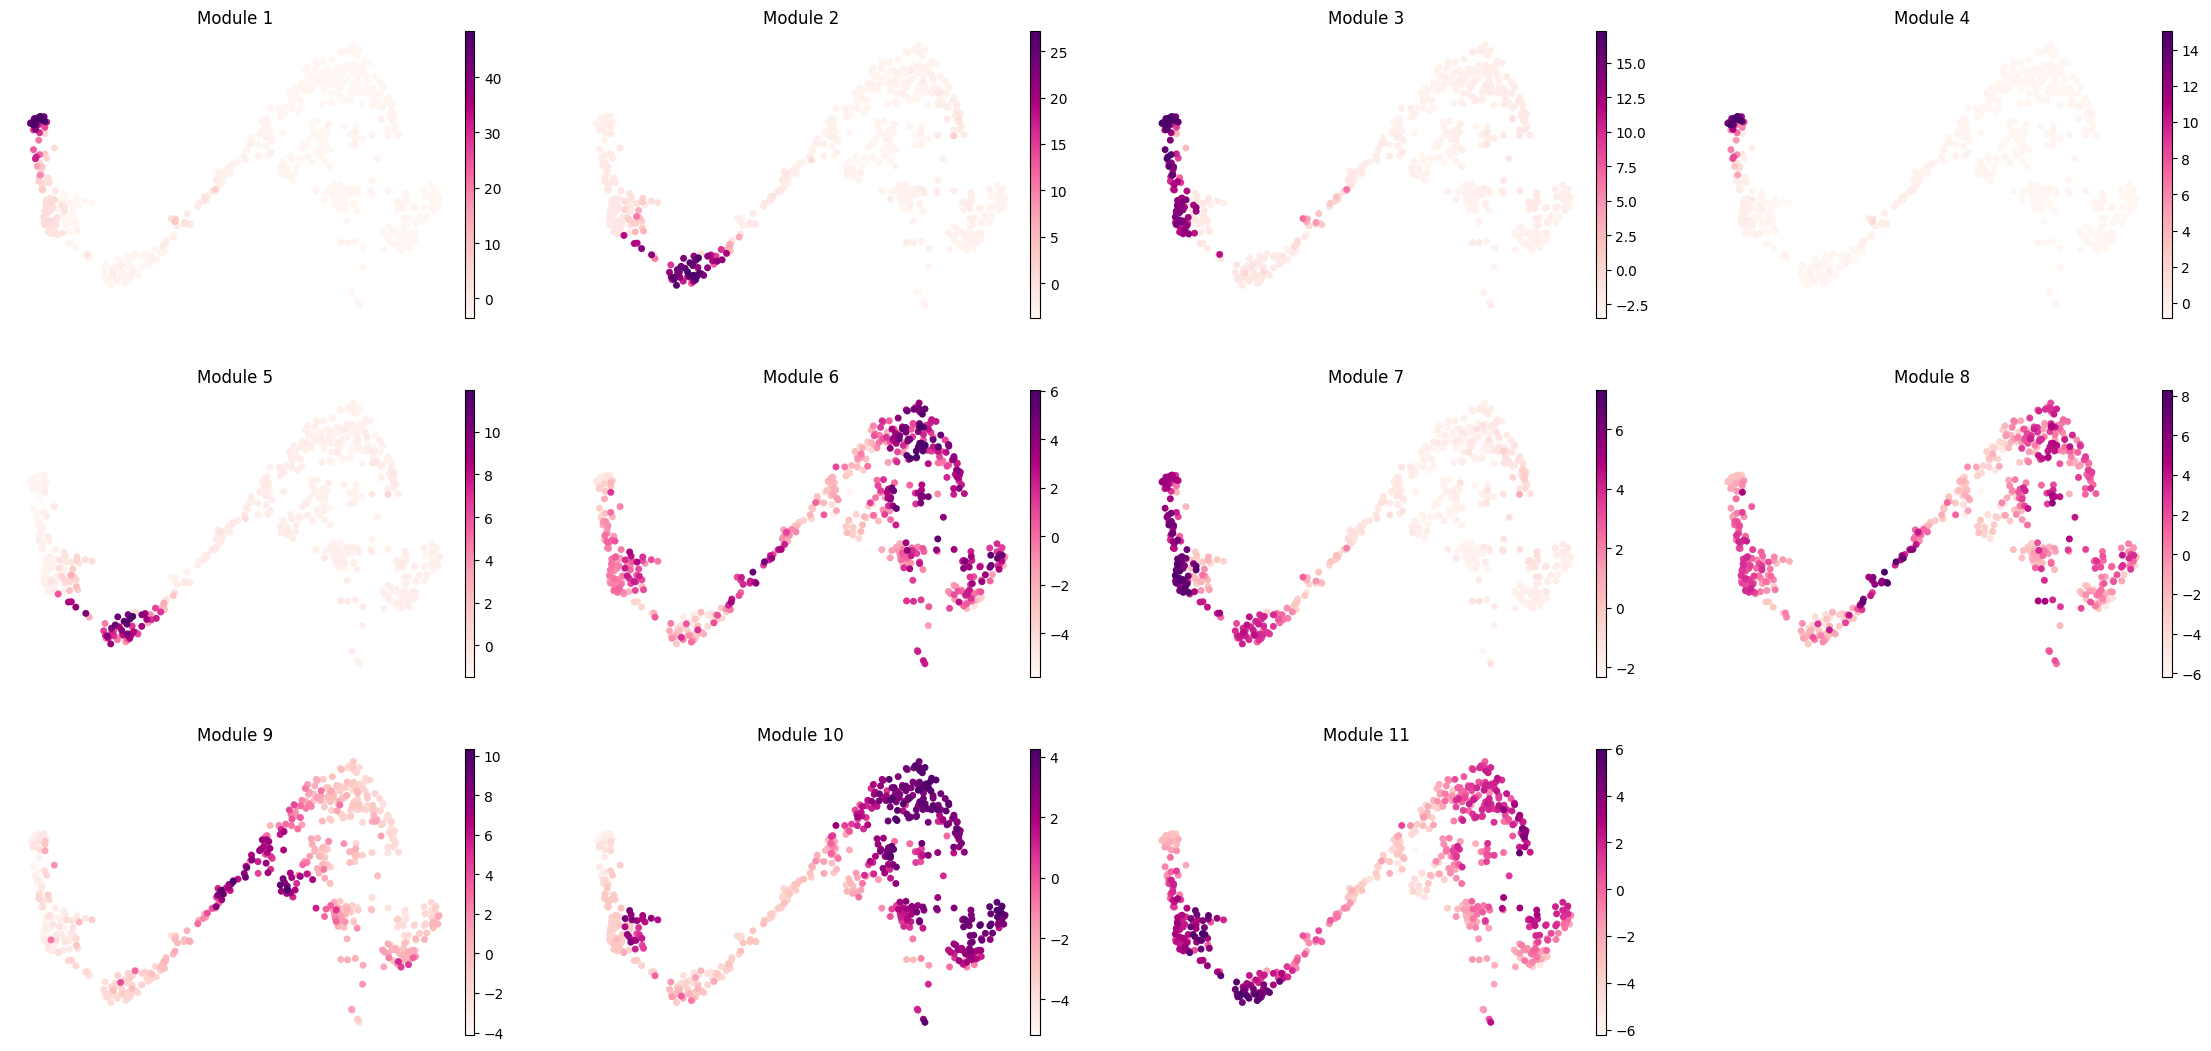

<Figure size 640x480 with 0 Axes>

In [92]:
from matplotlib.pyplot import rc_context

#with plt.rc_context({"figure.figsize": (8, 8), "figure.dpi": (300)}:
with rc_context({'figure.figsize': (6, 4)}):
    fig=sc.pl.umap(adata, color=module_cols, frameon=False,
               s=100, # 点大小
               # vmin=-1, vmax=1,      ##  去掉后，图片更美观，渐变更明显
               color_map="RdPu")
plt.savefig(fname="./figures/Module_score.pdf",dpi=1200, format="pdf")


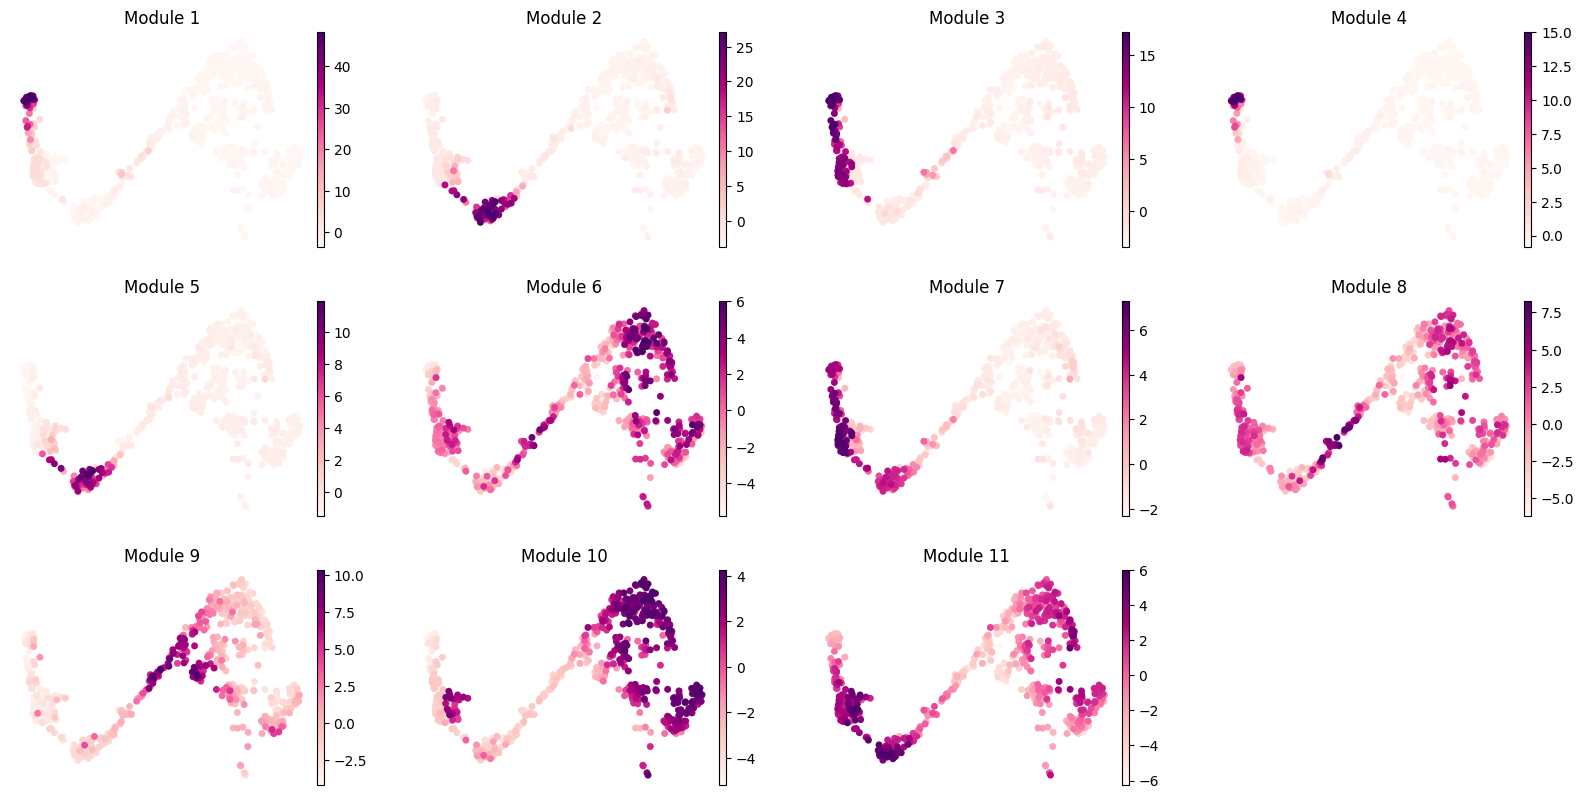

In [100]:
from matplotlib.pyplot import rc_context

#with plt.rc_context({"figure.figsize": (8, 8), "figure.dpi": (300)}:
with mpl.rc_context({'figure.figsize': (4, 3)}):
 fig = sc.pl.umap(adata, color=module_cols, frameon=False,
               s=100, # 点大小
               # vmin=-1, vmax=1,      ##  去掉后，图片更美观，渐变更明显
               color_map="RdPu",
               save="Module_score_2.pdf")
#plt.savefig(fname="./figures/Module_score.pdf",dpi=600, format="pdf")


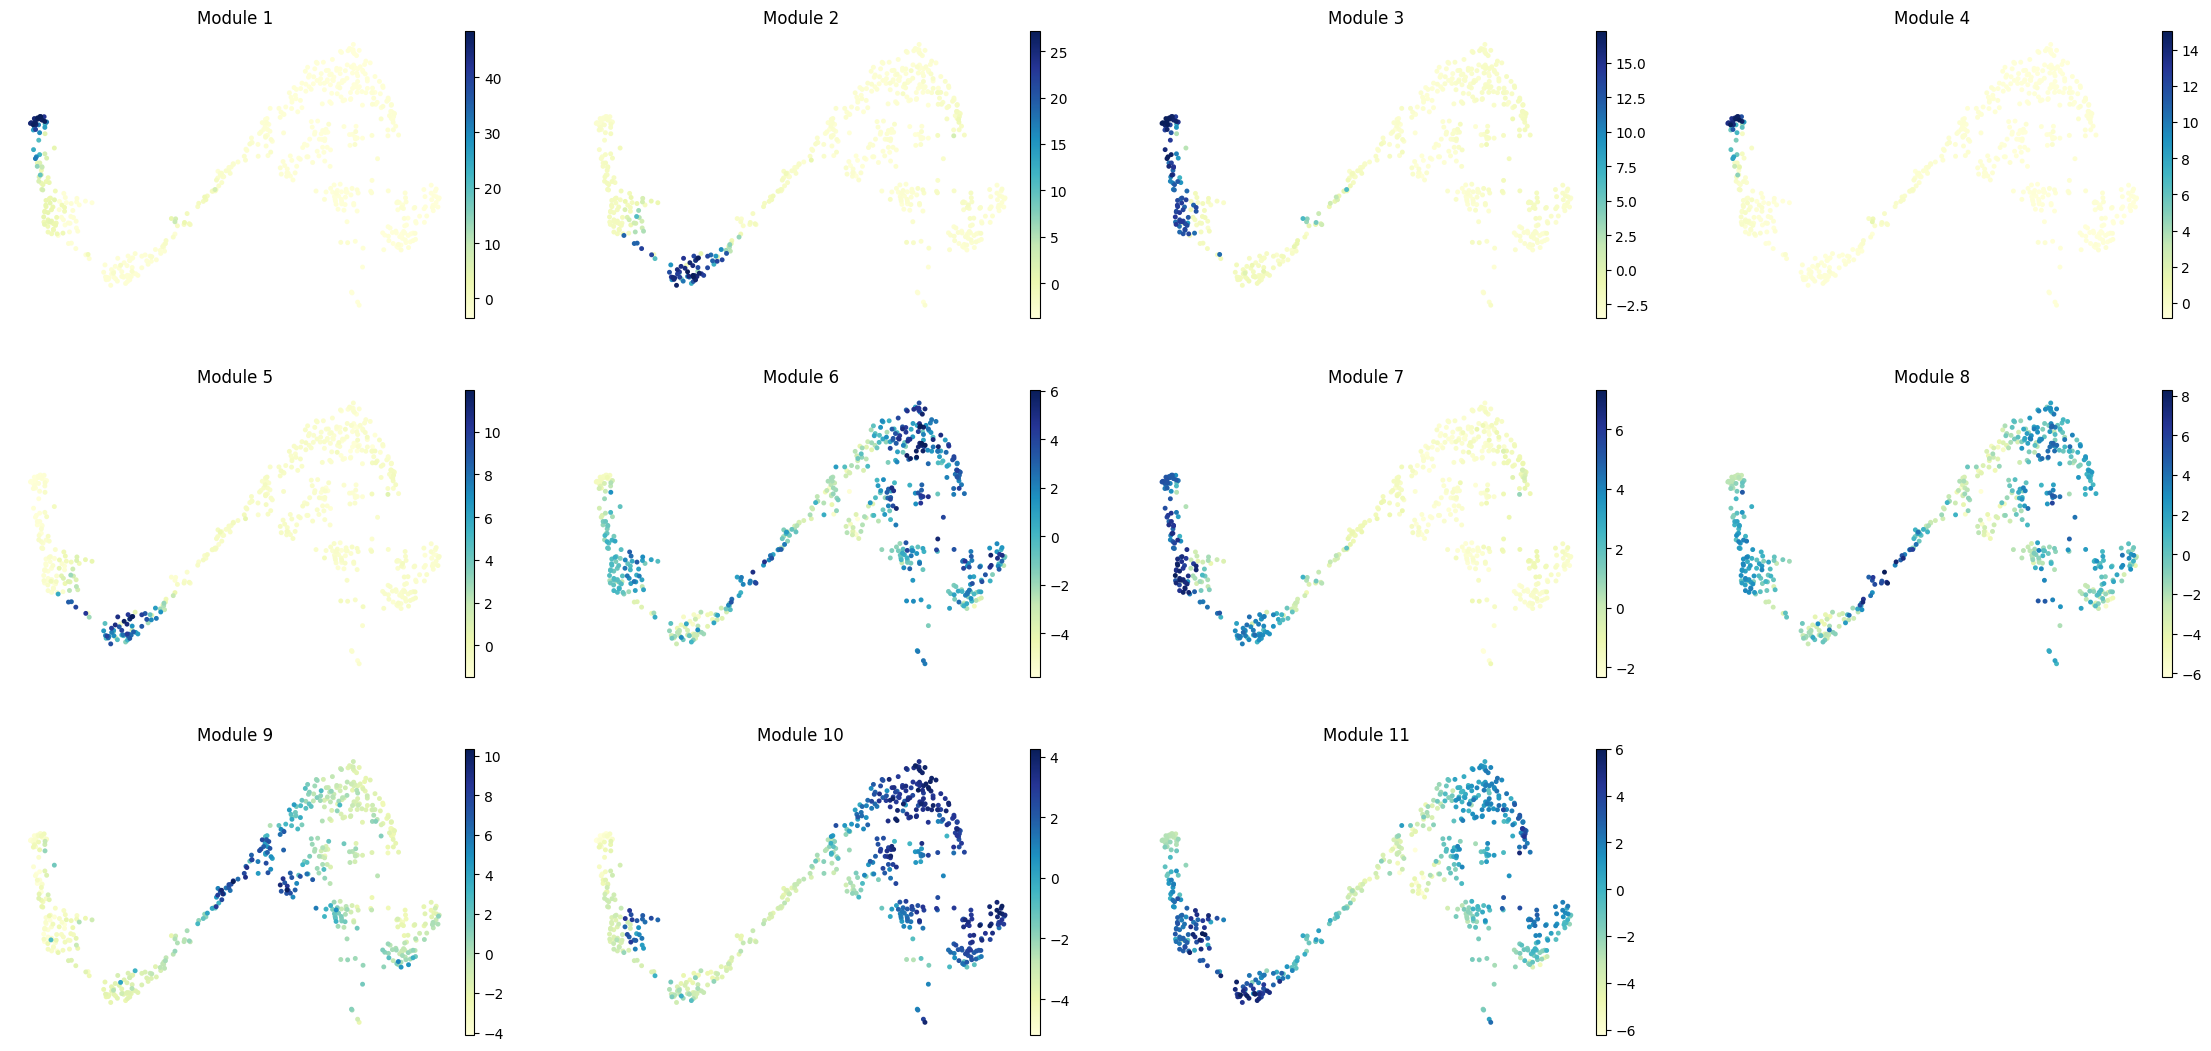

In [87]:
from matplotlib.pyplot import rc_context

#with plt.rc_context({"figure.figsize": (8, 8), "figure.dpi": (300)}:
with rc_context({'figure.figsize': (6, 4)}):
    sc.pl.umap(adata, color=module_cols, frameon=False, s=50, 
              # vmin=-1, vmax=1,      ##  去掉后，图片更美观，渐变更明显
               color_map="YlGnBu")